# DVD Inversion exercise (GNSS and InSAR- Low Noise)

This notebook solves DVD inversion exercises using all the datasets available

## Import libraries

In [2]:
import numpy as np
import corner
import matplotlib.pyplot as plt
import matplotlib
import h5py
from vmod import util
from vmod.data import Insar
from vmod.data import Gnss
from vmod.data import Joint
from vmod.source import Mctigue

## Read InSAR datasets

In [3]:
xsa,ysa,losa,azsa,incsa=np.loadtxt('examples/dvd/insar/Synth_Asc_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
xsd,ysd,losd,azsd,incsd=np.loadtxt('examples/dvd/insar/Synth_Des_Low_Correlated.csv',skiprows=1,delimiter=',',unpack=True)
azsa=np.radians(azsa)
azsd=np.radians(azsd)
incsa=np.radians(incsa)
incsd=np.radians(incsd)

In [4]:
nx=401
ny=nx
losa=np.reshape(losa,(ny,nx))[:,::-1].T
losd=np.reshape(losd,(ny,nx))[:,::-1].T
azsa=np.reshape(azsa,(ny,nx))[:,::-1].T
azsd=np.reshape(azsd,(ny,nx))[:,::-1].T
incsa=np.reshape(incsa,(ny,nx))[:,::-1].T
incsd=np.reshape(incsd,(ny,nx))[:,::-1].T

In [5]:
extenta=[np.min(xsa),np.max(xsa),np.min(ysa),np.max(ysa)]
extentd=[np.min(xsd),np.max(xsd),np.min(ysd),np.max(ysd)]
#util.mat2quad(losa,azsa,incsa,extenta,name='asc.txt',per=30,unit='m')
#util.mat2quad(losd,azsd,incsd,extentd,name='des.txt',per=30,unit='m')

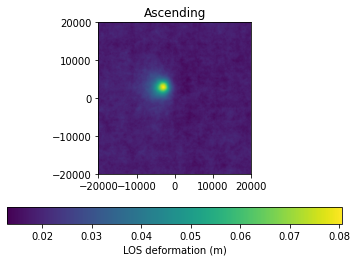

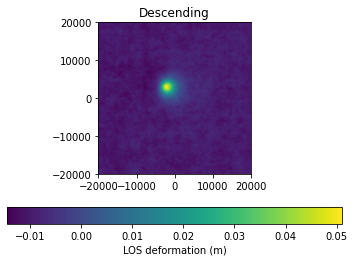

In [6]:
plt.figure()
plt.title('Ascending')
plt.imshow(losa,extent=extenta)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

plt.figure()
plt.title('Descending')
plt.imshow(losd,extent=extentd)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Read downsampled datasets

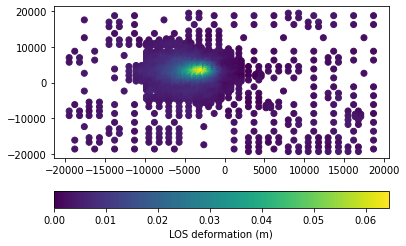

In [7]:
xsa,ysa,azsa,lksa,losa,elosa,refa=util.read_insar_csv('examples/dvd/insar/asc_low.txt')

plt.figure()
plt.scatter(xsa,ysa,c=losa)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

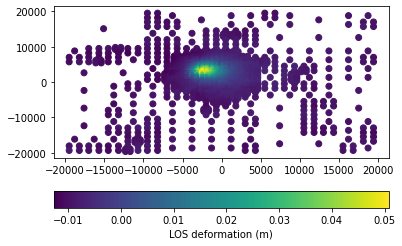

In [8]:
xsd,ysd,azsd,lksd,losd,elosd,refd=util.read_insar_csv('examples/dvd/insar/des_low.txt')

plt.figure()
plt.scatter(xsd,ysd,c=losd)
plt.colorbar(label='LOS deformation (m)',orientation='horizontal')

## Read GNSS dataset

In [9]:
csvfile='examples/dvd/gps/Synth_ENU_Low_Gaussian.csv'
xsg,ysg,uxs,uys,uzs=np.loadtxt(csvfile,skiprows=1,delimiter=',',unpack=True)
euxs=xsg*0+1e-3
euys=np.copy(euxs)
euzs=np.copy(euxs)
names=[str(i).zfill(4) for i in range(len(xsg))]

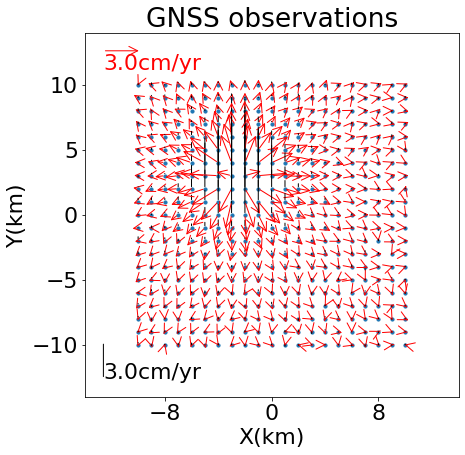

In [10]:
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xsg,ysg,uxs,uys,uzs,title='GNSS observations',scl=3.0,figsize=(6.7,6.7))

## Create joint data object

In [11]:
obsg=Gnss()
obsg.add_names(names)
obsg.add_xs(xsg)
obsg.add_ys(ysg)
obsg.add_ux(uxs)
obsg.add_uy(uys)
obsg.add_uz(uzs)
obsg.add_errx(euxs)
obsg.add_erry(euys)
obsg.add_errz(euzs)

obsa=Insar()
obsa.add_xs(xsa)
obsa.add_ys(ysa)
obsa.add_vecs(azsa,lksa)
obsa.add_los(losa)
obsa.add_err(elosa)
obsa.add_ref([20000,-20000,0,0,'3U'])

obsd=Insar()
obsd.add_xs(xsd)
obsd.add_ys(ysd)
obsd.add_vecs(azsd,lksd)
obsd.add_los(losd)
obsd.add_err(elosd)
obsd.add_ref([20000,-20000,0,0,'3U'])

obs=Joint()
obs.add_dataset(obsa,wt=1.0)
obs.add_dataset(obsd,wt=1.0)
obs.add_dataset(obsg,wt=np.max([len(xsa),len(xsd)])/(2*len(xsg)))

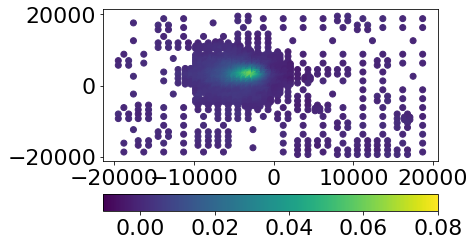

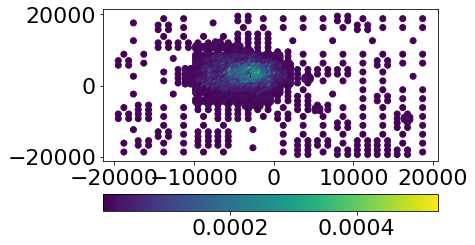

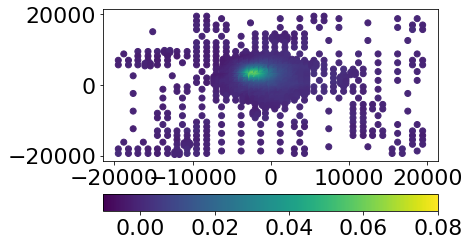

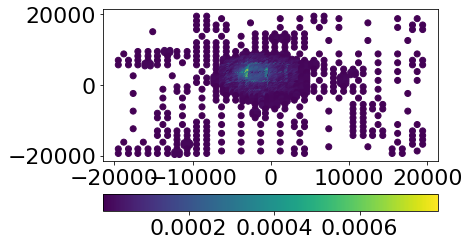

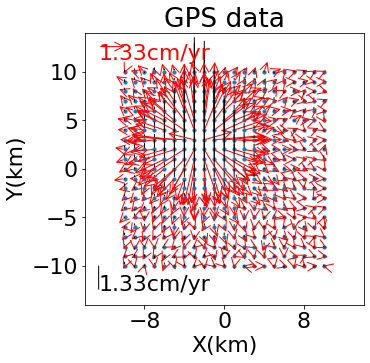

In [12]:
plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=elosa)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data(),vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=elosd)
plt.colorbar(orientation='horizontal')

util.plot_gnss(xsg,ysg,obsg.ux,obsg.uy,obsg.uz)

## Create model objects for each data type

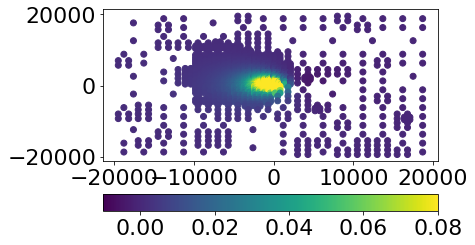

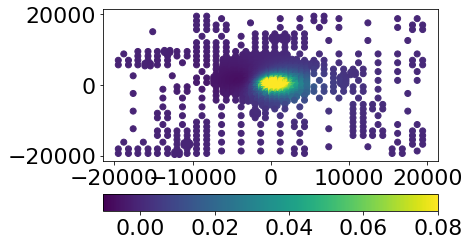

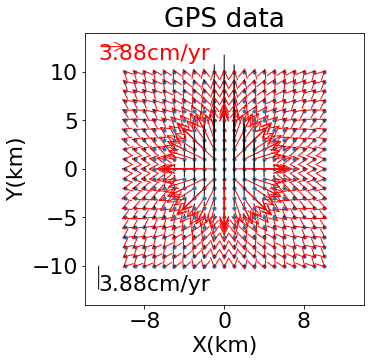

In [13]:
mcta=Mctigue(obsa)
losm=mcta.forward([0,0,2.0e3,1.5e3,1e6])

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctd=Mctigue(obsd)
losm=mctd.forward([0,0,2.0e3,1.5e3,1e6])

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

mctg=Mctigue(obsg)
uxm,uym,uzm=mctg.forward([0,0,2.0e3,1.5e3,1e6],unravel=False)
util.plot_gnss(xsg,ysg,uxm,uym,uzm)

## Create model object for joint dataset

In [14]:
mct=Mctigue(obs)
mct.set_x0([0,0,2e3,1.5e3,1e6])
#Bounds for parameters
mct.set_bounds(low_bounds = [-20000,-20000,1e2,1e2,1e5], high_bounds = [20000,20000,9e4,5e3,1e8])

## Create Inversion object

In [15]:
from vmod.inverse import Inverse

inv=Inverse(obs)
inv.register_source(mct)

## Least-squares inversion

In [16]:
ans=inv.nlsq()

print(ans.x)

0.08232260063083675
[-2.51705255e+03  2.87286671e+03  2.18443736e+03  1.01447252e+03
  1.55365366e+06]


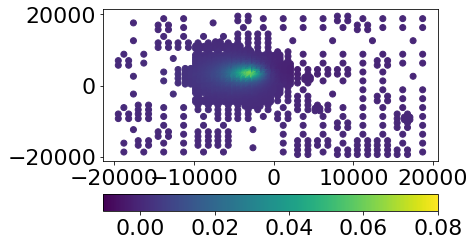

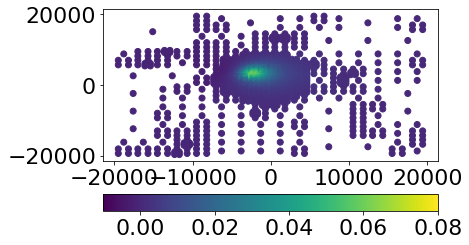

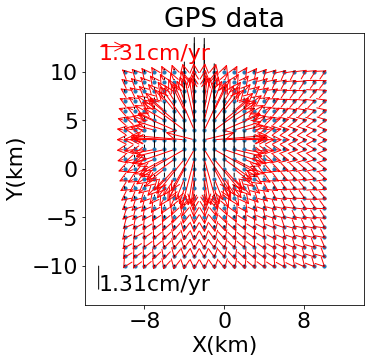

In [17]:
losm=mcta.forward(ans.x)

plt.figure()
plt.scatter(xsa,ysa,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

losm=mctd.forward(ans.x)

plt.figure()
plt.scatter(xsd,ysd,c=losm,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

uxm,uym,uzm=mctg.forward(ans.x,unravel=False)
util.plot_gnss(xsg,ysg,uxm,uym,uzm)

## Bayesian Inversion

In [17]:
#trace,MDL=inv.mcmc('joint_low_dP')

 [                  0%                  ] 1193 of 1100000 complete in 11.6 sec

/home/jovyan/notebooks/ASF/vmod_beta4/vmod/data/insar.py:113: RuntimeWarning: invalid value encountered in subtract
  los=ux*np.sin(self.inc)*np.cos(self.az)-uy*np.sin(self.inc)*np.sin(self.az)-uz*np.cos(self.inc)


 [-----------------100%-----------------] 1100000 of 1100000 complete in 20608.2 sec

In [18]:
import pickle
with open('joint_low_dP.pkl', 'rb') as f:
    data = pickle.load(f)

trace=[]
for key in data.keys():
    trace.append(data[key])

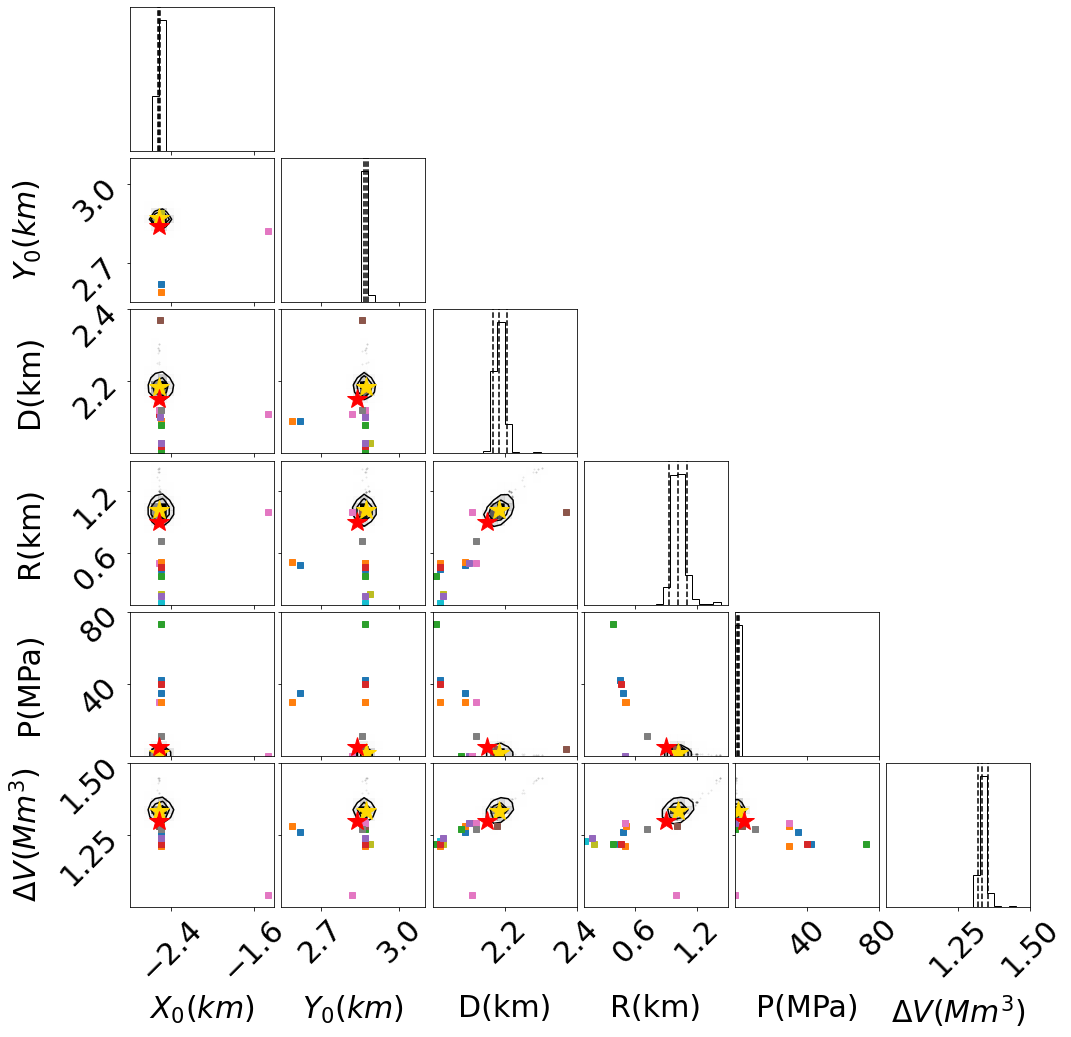

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
newdata[5,:]=np.copy((data[4,:]*(np.pi*data[3,:]**3)/4e9)*(1+(data[3,:]/data[2,:])**4))
newdata[4,:]=np.copy(data[4,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$']

trus1=[-2.50,2.62,2.09,0.48,35,1.26]
trus2=[-2.50,2.59,2.09,0.51,30,1.28]
trus3=[-2.50,2.87,2.08,0,0,1.27]
trus4=[-2.52,2.87,2.11,0,0,1.29]
trus5=[-2.51,2.87,2.10,0.5,0,1.29]
trus6=[-2.52,2.87,2.18,1.01,4,1.28]
trus7=[-2.52,2.87,2.12,0.50,30,1.29]
trus8=[-2.50,2.86,2.12,0.72,11,1.27]
trus9=[-2.50,2.89,2.03,0.20,484,1.22]
trus10=[-2.50,2.87,2.02,0.11,3340,1.23]
trus11=[-2.50,2.87,2.02,0.45,42,1.22]
trus12=[-2.50,2.87,2.02,0.50,30,1.21]
trus13=[-2.50,2.87,2.01,0.38,73,1.22]
trus14=[-2.50,2.87,2.02,0.46,40,1.22]
trus15=[-2.50,2.87,2.03,0.18,710,1.24]
trus16=[-2.51,2.86,2.37,1.00,4,0]
trus17=[-1.46,2.82,2.11,1.00,0,1.04]

trus=[trus1,trus2,trus3,trus4,trus5,trus6,trus7,trus8,trus9,trus10,trus11,trus12,trus13,trus14,trus15,trus16,trus17]

ranges=[(-2.8,-1.40),(2.55,3.1),(2.0,2.4),(0.1,1.5),(0,80),(1.0,1.5)]

ansx=[ans.x[0]/1e3,ans.x[1]/1e3,ans.x[2]/1e3,ans.x[3]/1e3,ans.x[4]/1e6,(ans.x[4]*np.pi*ans.x[3]**3/(4e9*1e6))*(1+(ans.x[3]/ans.x[2])**4)]

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,range=ranges,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

true=[-2.52,2.84,2.15,0.9,5,1.3]

for i,tru in enumerate(trus):
    #corner.overplot_lines(figure, np.array(tru), color="C"+str(i),linewidth=1)
    corner.overplot_points(figure, np.array(tru)[None], color="C"+str(i),marker='s')
corner.overplot_points(figure, np.array(ansx)[None], color="gold",marker='*',ms=20)
corner.overplot_points(figure, np.array(true)[None], color="red",marker='*',ms=20)
plt.savefig('histograms')

## Calculation of percentiles to upload the results

In [20]:
means=[np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower95=[np.percentile(data[i,:],5)-np.percentile(data[i,:],50) for i in range(data.shape[0])]
upper95=[np.percentile(data[i,:],95)-np.percentile(data[i,:],50) for i in range(data.shape[0])]
lower32=[np.percentile(data[i,:],32) for i in range(data.shape[0])]
upper68=[np.percentile(data[i,:],68) for i in range(data.shape[0])]

results=[means,lower95,upper95,lower32,upper68]

for res in results:
    for i in range(len(res)):
        if i in [0,1,2,3]:
            res[i]=res[i]
        elif i in [4,5]:
            res[i]=res[i]
        elif i in [6,7]:
            res[i]=res[i]
    print("%.2f,%.2f,%.2f,%.2f,%.2f,%.2f"%(tuple(res)))


-2.52,2.87,2.18,1.01,1.56,1.33
-0.01,-0.01,-0.02,-0.08,-0.34,-0.01
0.01,0.01,0.02,0.09,0.45,0.02
-2.52,2.87,2.18,0.99,1.46,1.33
-2.52,2.87,2.19,1.04,1.69,1.34


[-2.51755723e+03  2.87260175e+03  2.18466662e+03  1.01359467e+03
  1.55614353e+06]


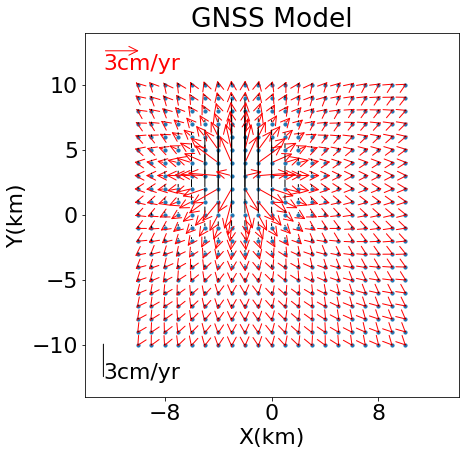

In [30]:
plt.rcParams.update({'font.size': 22})
xbest=np.array([np.median(data[0,:])*1e3,np.median(data[1,:])*1e3,np.median(data[2,:])*1e3,np.median(data[3,:])*1e3,np.median(data[4,:])*1e6])
print(xbest)
uxsm,uysm,uzsm=mctg.forward(xbest,unravel=False)
plt.rcParams.update({'font.size': 22})
util.plot_gnss(xsg,ysg,uxsm,uysm,uzsm,title='GNSS Model',scl=3,figsize=(6.7,6.7))

[-2.51755723e+03  2.87260175e+03  2.18466662e+03  1.01359467e+03
  1.55614353e+06] [-2.51755723e+03  2.87260175e+03  2.18466662e+03  1.01359467e+03
  1.55614353e+06]


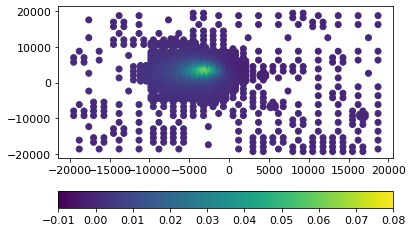

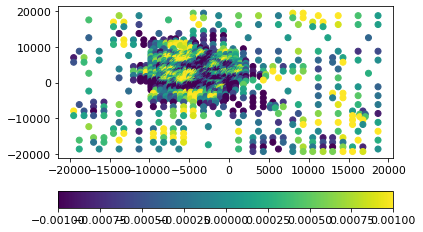

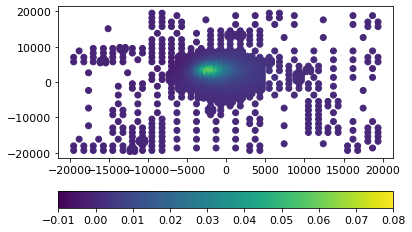

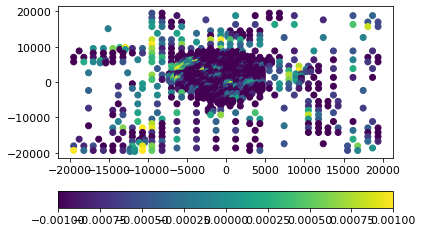

In [28]:
plt.rcParams.update({'font.size': 11})
ansa=np.concatenate((means[0:4],[means[4]]))
ansd=np.concatenate((means[0:4],[means[4]]))

print(ansa,ansd)

losma=mcta.forward(ansa)

plt.figure()
plt.scatter(xsa,ysa,c=losma,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsa,ysa,c=obsa.get_data()-losma,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

losmd=mctd.forward(ansd)

plt.figure()
plt.scatter(xsd,ysd,c=losmd,vmin=-0.01,vmax=0.08)
plt.colorbar(orientation='horizontal')

plt.figure()
plt.scatter(xsd,ysd,c=obsd.get_data()-losmd,vmin=-1e-3,vmax=1e-3)
plt.colorbar(orientation='horizontal')

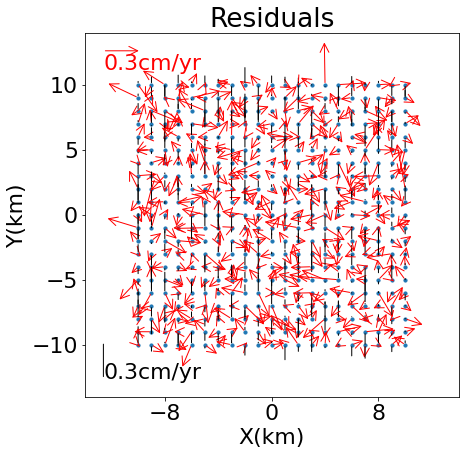

In [31]:
util.plot_gnss(xsg,ysg,uxs-uxsm,uys-uysm,uzs-uzsm,title='Residuals',scl=0.3,figsize=(6.7,6.7))

Text(0, 0.5, 'Y(km)')

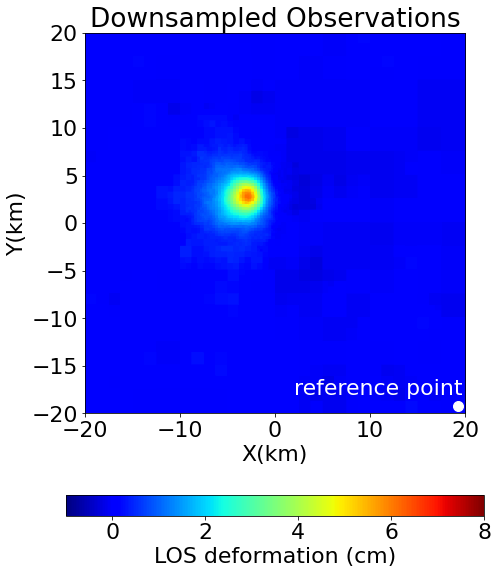

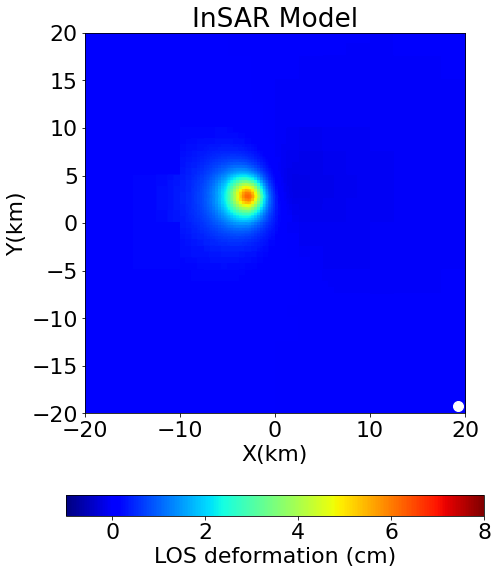

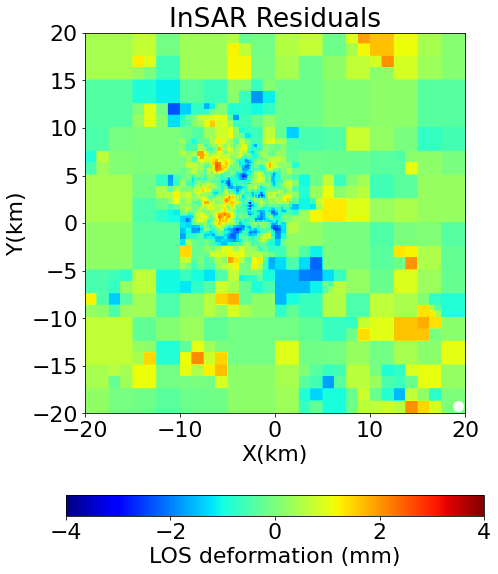

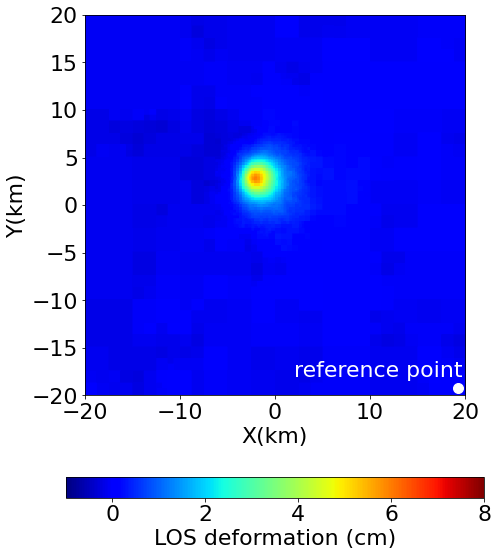

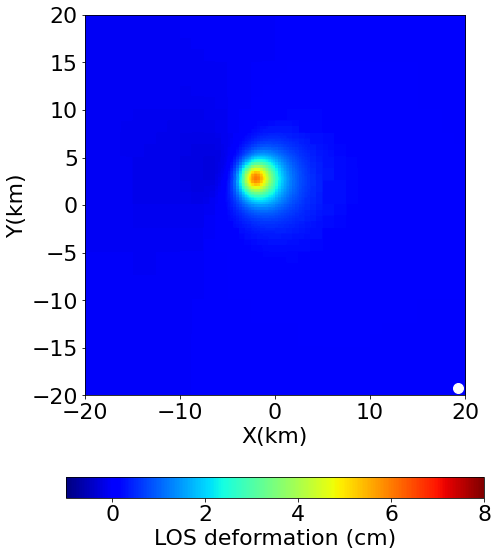

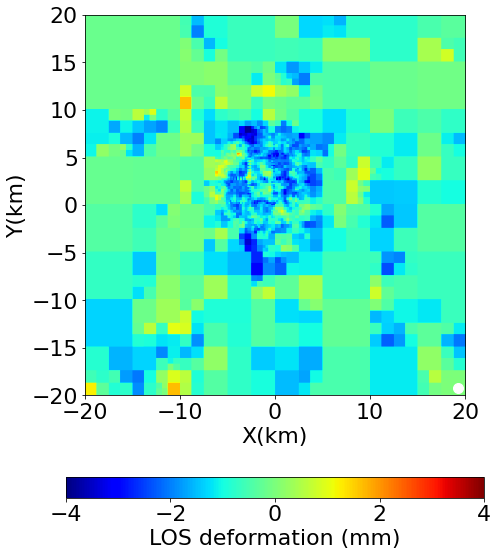

In [32]:
plt.rcParams.update({'font.size': 22})

qmapa,extent=util.los2npy(obsa.get_data(),'examples/dvd/insar/asc_low.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('Downsampled Observations')
plt.imshow(qmapa*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.text(2,-18,s='reference point',c='white')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapma,extent=util.los2npy(losma,'examples/dvd/insar/asc_low.txt',cref=False)

plt.figure(figsize=(10,10))
plt.title('InSAR Model')
plt.imshow(qmapma*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
plt.title('InSAR Residuals')
plt.imshow(qmapa*1e3-qmapma*1e3,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (mm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')


qmapd,extent=util.los2npy(obsd.get_data(),'examples/dvd/insar/des_low.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Downsampled observations')
plt.imshow(qmapd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.text(2,-18,s='reference point',c='white')
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

qmapmd,extent=util.los2npy(losmd,'examples/dvd/insar/des_low.txt',cref=False)

plt.figure(figsize=(10,10))
#plt.title('Model')
plt.imshow(qmapmd*1e2,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-1,vmax=8,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (cm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

plt.figure(figsize=(10,10))
#plt.title('Residuals')
plt.imshow((qmapd-qmapmd)*1e3,extent=[extent[0]/1e3,extent[1]/1e3,extent[2]/1e3,extent[3]/1e3],vmin=-4,vmax=4,cmap='jet')
plt.colorbar(orientation='horizontal',label='LOS deformation (mm)',shrink=0.75)
plt.scatter([19.2],[-19.2],c='white',s=100)
plt.xlabel('X(km)')
plt.ylabel('Y(km)')

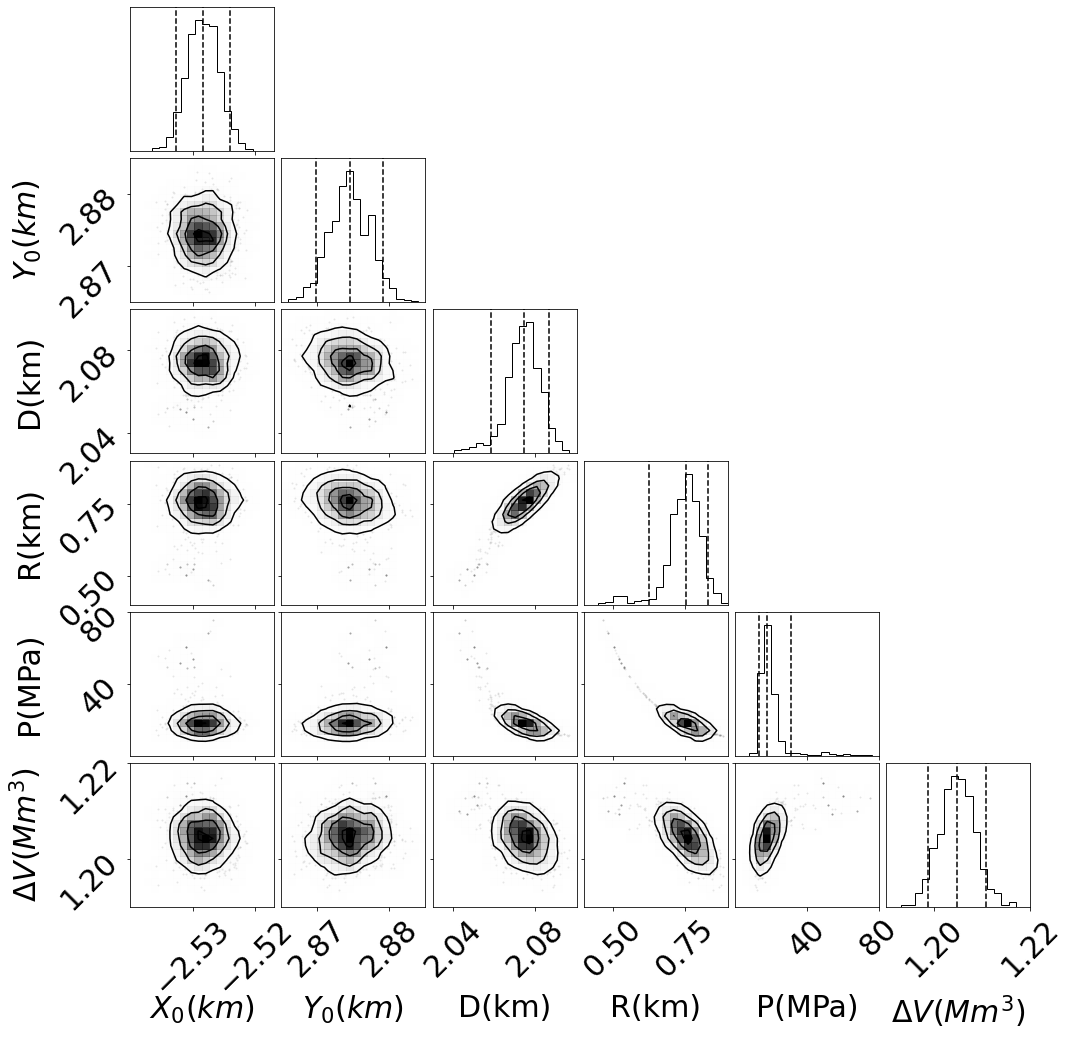

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
data=[]
labels=[]
parnames,orders=inv.get_parnames_orders()
for i,tr in enumerate(trace):
    data.append(tr[:])
    labels.append(parnames[i])
data=np.vstack(data)
newdata=np.zeros((data.shape[0]+1,data.shape[1]))
newdata[:,:]=np.nan
newdata[0:4,:]=np.copy(data[0:4,:])
newdata[4,:]=np.copy(data[4,:]*2e10/(np.pi*data[3,:]**3))
newdata[5,:]=np.copy(data[4,:])

data=np.copy(newdata)
data[0,:]=data[0,:]/1e3
data[1,:]=data[1,:]/1e3
data[2,:]=data[2,:]/1e3
data[3,:]=data[3,:]/1e3
data[4,:]=data[4,:]/1e6
data[5,:]=data[5,:]/1e6
labels=[r'$X_{0} (km)$',r'$Y_{0} (km)$','D(km)','R(km)','P(MPa)','$\Delta{V} (Mm^{3})$']

ranges=[(-2.54,-2.517),(2.865,2.885),(2.03,2.1),(0.4,0.9),(0,80),(1.19,1.22)]

plt.rcParams.update({'font.size': 30})
figure = corner.corner(data.T, labels=labels,
                       quantiles=[0.05, 0.5, 0.95],smooth=0.7,range=ranges,max_n_ticks=2,labelpad=0.3,
                       show_titles=False, label_kwargs={"fontsize": 30}, title_kwargs={"fontsize": 30})

figure.savefig('histograms_joint_high.pdf', bbox_inches='tight', format='pdf')